#### Necessary Imports

In [405]:
# !pip install torchtext==0.6.0 --quiet
# !pip install nltk
# !python -m spacy download en_core_web_sm --quiet
# !python -m spacy download fr_core_news_sm --quiet

In [406]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, BucketIterator
import numpy as np
import pandas as pd
import spacy
import random
from torchtext.data.metrics import bleu_score
from pprint import pprint

# Seeding for reproducible results everytime
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [407]:
spacy_german = spacy.load("fr_core_news_sm")
spacy_english = spacy.load("en_core_web_sm")

In [408]:
def tokenize_german(text):
  return [token.text for token in spacy_german.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

### Sample Run ###
sample_text = "I love machine learning"
print(tokenize_english(sample_text))

['I', 'love', 'machine', 'learning']


In [409]:
filepath = '/data/hwyu/data/libri/'

train_en_path = filepath+"train/train.en"
train_de_path = filepath+"train/train_gtranslate.fr" 

train_oth_en_path = filepath+"train/other.en"
train_oth_de_path = filepath+"train/other_gtranslate.fr" 

test_eng_path = filepath+"test/test.en"
test_de_path = filepath+"test/test_gtranslate.fr"

test_dev_eng_path = filepath+"test/dev.en"
test_dev_de_path = filepath+"test/dev_gtranslate.fr"

In [410]:
end_line = 100000  # 끝 라인 (포함하지 않음)

train_en_sub_raw = []  # 추출한 데이터를 저장할 리스트

with open(train_en_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_en_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

with open(train_oth_en_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_en_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break
            
limit_data_len = 120000
train_en_sub_raw = train_en_sub_raw[:limit_data_len]
# 데이터 확인
print(len(train_en_sub_raw))
print(train_en_sub_raw[:10])

108640
['ADIEU VALENTINE ADIEU', 'PROVE IT DANGLARS', 'SAID FRANZ', 'SAID FRANZ', 'FERNAND MONDEGO', 'AND THE CORRIDOR', 'FOR ANDREA RONDOLO', 'FOR ANDREA RONDOLO', 'SAID FERNAND', 'SAID ANDREA']


In [411]:
train_fr_sub_raw = []

with open(train_de_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_fr_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

with open(train_oth_de_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_fr_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break
train_fr_sub_raw = train_fr_sub_raw[:limit_data_len]
# 데이터 확인
print(len(train_fr_sub_raw))
print(train_fr_sub_raw[:10])

108640
['"Adieu, Valentine, adieux!', 'Prouve, Danglars.', 'Dit Franz.', 'Dit Franz.', '"" Fernand Mondego.', '"" Et le couloir?', '"" Pour Andrea Rondolo?', '"" Pour Andrea Rondolo?', '"A déclaré Fernand.', '"Dit Andrea.']


In [412]:
with open(test_eng_path, "r", encoding="utf-8") as file:
    test_en_raw = file.readlines()
    
with open(test_de_path, "r", encoding="utf-8") as file:
    test_fr_raw = file.readlines()

with open(test_dev_eng_path, "r", encoding="utf-8") as file:
    test_dev_en_raw = file.readlines()
    
with open(test_dev_de_path, "r", encoding="utf-8") as file:
    test_dev_fr_raw = file.readlines()

print(test_en_raw[:2])
print(test_fr_raw[:2])

print(len(test_en_raw))
print(len(test_fr_raw))
test_en_raw += test_dev_en_raw
test_fr_raw += test_dev_fr_raw

['IN ANOTHER THE GROUND WAS CUMBERED WITH RUSTY IRON MONSTERS OF STEAM BOILERS WHEELS CRANKS PIPES FURNACES PADDLES ANCHORS DIVING BELLS WINDMILL SAILS AND I KNOW NOT WHAT STRANGE OBJECTS ACCUMULATED BY SOME SPECULATOR AND GROVELLING IN THE DUST UNDERNEATH WHICH HAVING SUNK INTO THE SOIL OF THEIR OWN WEIGHT IN WET WEATHER THEY HAD THE APPEARANCE OF VAINLY TRYING TO HIDE THEMSELVES\n', 'THE CLASH AND GLARE OF SUNDRY FIERY WORKS UPON THE RIVER SIDE AROSE BY NIGHT TO DISTURB EVERYTHING EXCEPT THE HEAVY AND UNBROKEN SMOKE THAT POURED OUT OF THEIR CHIMNEYS\n']
["Dans un autre, le terrain était encombré de monstres en fer rouillé de chaudières à vapeur, de roues, de manivelles, de tuyaux, de fours, de pagaies, d'ancrages, de cloches, de voiliers, et je ne sais pas quels objets étranges, accumulés par un spéculateur, et Se creusant dans la poussière, sous laquelle - s'étant enfoncée dans le sol de leur propre poids par temps humide - ils avaient l'apparence d'essayer vainement de se cacher.\n

In [413]:
# # def find_sentences_with_numbers(filename):
# def find_sentences_with_numbers(lines):
#     # with open(filename, 'r') as file:
#         # lines = file.readlines()
#         indices = []
#         for i, line in enumerate(lines):
#             # @ any(): 제너레이터 표현식을 통해 반복 가능한 객체를 받고, 그 객체의 요소 중 하나라도 True로 평가되는 경우 True를 반환
#             if any(char.isdigit() for char in line):
#                 print(f"Line {i}: {line}")
#                 indices.append(i)
#         return indices

# # 파일명을 지정하여 함수를 호출합니다.
# # find_sentences_with_numbers("your_text_file.txt")
# # indices_fr = find_sentences_with_numbers(train_fr_sub_raw) # 734 
# indices_en = find_sentences_with_numbers(train_en_sub_raw) # 20
# # indices_en_test = find_sentences_with_numbers(test_en_raw) # 0
# # indices_en_test = find_sentences_with_numbers(test_fr_raw) # 18

In [414]:
from unicodedata import normalize

def unicodeToAscii(s):
    return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

def normalizeString(s):
    return unicodeToAscii(s.lower())

def normalizeStrings(lines):
    return [normalizeString(s) for s in lines]

def check_characters_in_file(lines):

    # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
    all_characters = set()

    # 각 문장을 반복하면서 문자를 세트에 추가
    for line in lines:
        # 개행 문자 및 불필요한 공백 제거
        line = line.strip()
        # 문장에 포함된 모든 문자를 세트에 추가
        all_characters.update(set(line))

    return all_characters
# characters_in_file = check_characters_in_file(normalizeStrings(test_fr_raw))
characters_in_file = check_characters_in_file(normalizeStrings(train_fr_sub_raw)) # other_gtranslatefr : 모든 알파벳과 숫자, ')}_%+?&:"/-{[(.,;*!$[, 스페이 
print("파일에 포함된 모든 문자:", characters_in_file)

파일에 포함된 모든 문자: {'v', 'k', '{', '9', ';', ']', '-', 'm', 'c', '6', 'n', '_', 'f', 't', '"', '(', 'b', '[', 'l', '*', '+', 'g', '0', '5', '/', '1', '4', 'p', ',', '?', 'x', '3', '7', 'z', 'y', '2', '8', 'w', 'r', 'a', 'u', ' ', 'q', 'e', '$', '!', '%', "'", '&', 'i', 'j', 'd', 's', ')', 'o', 'h', '}', ':', '.'}


In [415]:
def check_characters_in_file(file_path):
    # 파일을 열고 모든 내용을 읽어들임
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
    all_characters = set()

    # 각 문장을 반복하면서 문자를 세트에 추가
    for line in lines:
        # 개행 문자 및 불필요한 공백 제거
        line = line.strip()
        # 문장에 포함된 모든 문자를 세트에 추가
        all_characters.update(set(line))

    return all_characters

# 파일에서 사용된 모든 문자 확인
# characters_in_file = check_characters_in_file(test_eng_path) # 알파벳(모두)과 스페이스 밖에 없음 
# characters_in_file = check_characters_in_file(test_de_path) # 숫자는 7, 9 없음 / 스페이스랑 * ) . ; : ! ? $ - " , ' (

# train.en 은 작은 따옴표 없애서 dont, thats 이런 식으로 돼있고 other.en은 작은 따옴표 있어서 don't, that's 이렇게 돼있음(thats도 있긴험)
characters_in_file = check_characters_in_file(train_en_path) # 알파벳(모두), 숫자(모두), 스페이스
# characters_in_file = check_characters_in_file(train_de_path) # 알파벳(모두), 숫자(모두), 스페이스, * [ ) . ; : ! ? $ ] - " , & ' , _ 
print("파일에 포함된 모든 문자:", characters_in_file)

파일에 포함된 모든 문자: {'5', 'K', 'Y', 'B', '1', '4', '9', 'N', 'H', 'Z', '3', '6', '7', 'E', '2', 'J', '8', 'D', 'T', 'R', 'M', ' ', 'X', 'C', 'I', 'A', 'P', 'L', 'F', 'W', 'S', 'G', 'Q', 'U', 'O', 'V', '0'}


In [416]:
# print(train_fr_sub_raw[550])
# print()
# print(train_fr_g_sub_raw[550]) # en과 동일
# print()
# print(train_en_sub_raw[550]) # train_fr_sub_raw[550] 의 콜론 이후는 번역x

# 의미는 같은데 fr의 ; : 가 en에 없음 
# print(train_fr_sub_raw[616])
# print()
# print(train_fr_g_sub_raw[616])
# print()
# print(train_en_sub_raw[616])

# print(train_fr_sub_raw[702])
# print(train_en_sub_raw[702]) # fr의 숫자를 영어로 씀 

# ?? 숫자 뭐지 
# print(train_fr_sub_raw[3135]) # « Six cent mille?
# print()
# print(train_fr_g_sub_raw[3135]) # ~~~ 700 000 000 000
# print()
# print(train_en_sub_raw[3135]) # SIX HUNDRED THOUSAND700000800000

# print(train_fr_sub_raw[11486])
# print()
# print(train_fr_g_sub_raw[11486]) # en 처럼 3651364
# print()
# print(train_en_sub_raw[11486]) # HIM 옆에 의미없는 3651364 가 붙어있음  

print(train_fr_sub_raw[4191]) # 이것만 문장 더 있고 g trans가 맞음
print()
# print(train_fr_g_sub_raw[4191])
# print()
print(train_en_sub_raw[4191])

Puis enfermant le reçu de monte cristos dans un petit livre de poche, il ajouta que oui, à 12 heures, je serai loin, puis il double verrouillé sa porte vide tous ses tiroirs recueillis environ cinquante mille francs en billets de banque ont brûlé plusieurs papiers laissés à d'autres exposés à la vue1876

THEN ENCLOSING MONTE CRISTOS RECEIPT IN A LITTLE POCKET BOOK HE ADDED YES COME AT TWELVE OCLOCK I SHALL THEN BE FAR AWAY THEN HE DOUBLE LOCKED HIS DOOR EMPTIED ALL HIS DRAWERS COLLECTED ABOUT FIFTY THOUSAND FRANCS IN BANK NOTES BURNED SEVERAL PAPERS LEFT OTHERS EXPOSED TO VIEW1876


In [417]:
import unicodedata
from unicodedata import normalize
import re

# def unicodeToAscii(s):
#     # return ''.join( # 악센트 있는 문자 통째로 제거
#     #     c for c in unicodedata.normalize('NFD', s)
#     #     if unicodedata.category(c) != 'Mn'
#     # )
#     # 악센트만 제거
#     return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

def normalizeString(s):
    # s = unicodeToAscii(s.lower().strip())
    s = unicodeToAscii(s)
    # s = re.sub(r"([.!?\"])", r" \1", s) # 마침표, 느낌표, 물음표, 따옴표 앞에 공백을 추가
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # G 영문 알파벳과 마침표(.), 느낌표(!), 물음표(?)를 제외한 모든 문자를 공백으로 대체/ +: 해당 패턴이 한 번 이상 반복
    s = re.sub(r"[^a-zA-Z]+", r" ", s) # 이 코드 실행 후 strip() 안하면 문장 앞뒤 제거됐을 때 공백생김 
    return s.strip()

print(train_fr_sub_raw[2222]) 
print(normalizeString(train_fr_sub_raw[2222]))

print(train_fr_sub_raw[3332]) 
print(normalizeString(train_fr_sub_raw[3332]))

Oh, Beauchamp, Beauchamp, comment puis-je aborder le mien?
Oh Beauchamp Beauchamp comment puis je aborder le mien
Mais, après m'avoir péché, peut-être plus profondément que d'autres, je ne me reposerai jamais avant d'avoir déchiré les semblables de mes semblables et j'ai découvert leurs faiblesses. Je les ai toujours trouvés; Et plus encore, je le répète avec joie, avec triomphe, j'ai toujours trouvé une preuve de perversité humaine ou d'erreur.
Mais apres m avoir peche peut etre plus profondement que d autres je ne me reposerai jamais avant d avoir dechire les semblables de mes semblables et j ai decouvert leurs faiblesses Je les ai toujours trouves Et plus encore je le repete avec joie avec triomphe j ai toujours trouve une preuve de perversite humaine ou d erreur


In [418]:
def normalizeStrings(lines):
    return [normalizeString(s) for s in lines]
    
train_fr_sub = normalizeStrings(train_fr_sub_raw)
train_en_sub = normalizeStrings(train_en_sub_raw)
test_fr = normalizeStrings(test_fr_raw)
test_en = normalizeStrings(test_en_raw)

In [419]:
print(train_fr_sub[100:105])
print(train_fr_sub_raw[100:105])
print()

# print(train_en_sub[1000:1005])
# print(train_en_sub_raw[1000:1005])
# print()

# print(test_fr[100:105])
# print(test_fr_raw[100:105])
# print()

# print(test_en[100:105])
# print(test_en_raw[100:105])

['Le celebre Cucumetto poursuivi dans les Abruzzes chasse du royaume de Naples ou il avait mene une guerre reguliere avait traverse le Garigliano comme Manfred et s etait refugie sur les rives de l Amasine entre Sonnino et Juperno', 'Vous connaissez les environs de Paris alors', 'Vous connaissez les environs de Paris alors', 'Franz prit la lampe et entra dans la grotte souterraine suivie de Gaetano', 'Gaetano ne se trompait pas']
['"Le célèbre Cucumetto, poursuivi dans les Abruzzes, chassé du royaume de Naples, où il avait mené une guerre régulière, avait traversé le Garigliano, comme Manfred, et s\'était réfugié sur les rives de l\'Amasine entre Sonnino et Juperno.', '"" Vous connaissez les environs de Paris, alors?', '"" Vous connaissez les environs de Paris, alors?', 'Franz prit la lampe et entra dans la grotte souterraine, suivie de Gaetano.', 'Gaetano ne se trompait pas.']



In [420]:
german = Field(tokenize=tokenize_german,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>", 
               batch_first=True)

english = Field(tokenize=tokenize_english,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>", 
               batch_first=True)

In [421]:
from torchtext.data import Dataset, Example

def create_dataset(text_list, field_name, field_obj):
    # G Example.fromlist(data_list, fields) : field 정의에 따라 데이터를 적절히 처리하고 Example 객체를 생성
    #   data_list의 순서는 필드 정의에서 지정한 순서와 일치해야 합니다.
    examples = [Example.fromlist([text], [(field_name, field_obj)]) for text in text_list]
    return Dataset(examples, fields=[(field_name, field_obj)])

In [422]:
from torchtext.vocab import FastText, GloVe

flag_pretrained_emb = True 

train_data = create_dataset(train_fr_sub, 'src', german)

train_data.fields['trg'] = english
train_en_data = create_dataset(train_en_sub, 'trg', english)

for i in range(len(train_data)):
    train_data[i].trg = train_en_data[i].trg

test_data = create_dataset(test_fr, 'src', german)

test_data.fields['trg'] = english
test_en_path = create_dataset(test_en, 'trg', english)

for i in range(len(test_data)):
    test_data[i].trg = test_en_path[i].trg

max_vocab_size = 10000 # 12000
if flag_pretrained_emb :
    # print("loading fr_pretrained_emb. . .")
    # fr_pretrained_emb = GloVe(name='6B', dim=300, cache='/data/hwyu/1_seq2seq/cache_dir_fr') # 텍스트가 6억 단어로 훈련된 것 / 50, 100, 200, 300
    # print("loading en_pretrained_emb. . .")
    # en_pretrained_emb = GloVe(name='6B', dim=300, cache='/data/hwyu/1_seq2seq/cache_dir_en')
    
    print("loading fr_fasttext. . .")
    fr_pretrained_emb = torch.load('/data/hwyu/1_seq2seq/fr_fasttext_dim300.pt')
    print("loading en_fasttext. . .")
    en_pretrained_emb = torch.load('/data/hwyu/1_seq2seq/en_fasttext_dim300.pt')
    
    print("load 완료\n")

    german.build_vocab(train_data, max_size=max_vocab_size, min_freq=3, vectors=fr_pretrained_emb)
    english.build_vocab(train_data, max_size=max_vocab_size, min_freq=3, vectors=en_pretrained_emb)
else :
    german.build_vocab(train_data, max_size=max_vocab_size, min_freq=3)
    english.build_vocab(train_data, max_size=max_vocab_size, min_freq=3)

print(english.vocab.freqs.most_common(10))
print(german.vocab.freqs.most_common(10))

loading fr_fasttext. . .
loading en_fasttext. . .
load 완료

[('the', 126323), ('and', 70427), ('of', 66460), ('to', 59303), ('a', 46156), ('in', 35956), ('i', 33435), ('he', 29097), ('that', 28314), ('was', 25627)]
[('de', 89949), ('a', 77983), ('et', 69842), ('la', 59383), ('le', 49746), ('il', 43426), ('l', 41416), ('que', 34252), ('un', 34044), ('les', 33987)]


In [423]:
if flag_pretrained_emb :
    fr_pretrained_emb.__dict__.keys()

In [424]:
for data in train_data:
    print(f"txt 파일 : {train_en_sub[0]}")
    print(data.trg) # ?? 왜 공백 
    print(f"txt 파일 : {train_fr_sub[0]}")
    print(data.src) 
    # print("German - ",*data.src, " Length - ", len(data.src))
    break

txt 파일 : ADIEU VALENTINE ADIEU
['adieu', 'valentine', 'adieu']
txt 파일 : Adieu Valentine adieux
['adieu', 'valentine', 'adieux']


In [425]:
# print(english.vocab.stoi)  # 단어를 정수로 매핑한 딕셔너리 출력
print(list(german.vocab.stoi.items())[:10])
print(list(german.vocab.stoi.items())[5000:5010])

[('<unk>', 0), ('<pad>', 1), ('<sos>', 2), ('<eos>', 3), ('de', 4), ('a', 5), ('et', 6), ('la', 7), ('le', 8), ('il', 9)]
[('joint', 5000), ('jonathan', 5001), ('labyrinthe', 5002), ('laches', 5003), ('ling', 5004), ('lourdes', 5005), ('manches', 5006), ('moustache', 5007), ('naturelles', 5008), ('nommer', 5009)]


In [426]:
print("단어 사전의 크기 확인:")
print(f"Unique tokens in source (de) vocabulary: {len(german.vocab)}") # max : 16926 (g trans)
print(f"Unique tokens in target (en) vocabulary: {len(english.vocab)}") # max : 16197

if flag_pretrained_emb :
    print("\n임베딩 벡터 확인:")
    print("German Embedding Shape:", german.vocab.vectors.shape)
    print("English Embedding Shape:", english.vocab.vectors.shape)
    
    print("\n임베딩 벡터 값 확인:")
    print("German Embedding Vectors:")
    print(german.vocab.vectors)
    print("English Embedding Vectors:")
    print(english.vocab.vectors)
    
    # G 특별 토큰들에 대한 임베딩은 훈련되지 않습니다. 
    #  따라서 초기화 단계에서는 이러한 토큰들의 임베딩은 보통 0으로 설정됩니다.
    # print(torch.all(english.vocab.vectors[0] == english.vocab.vectors[1]))
    # print(torch.all(english.vocab.vectors[1] == english.vocab.vectors[2]))
    # print(torch.all(english.vocab.vectors[2] == english.vocab.vectors[3]))
    # print(torch.all(english.vocab.vectors[3] == english.vocab.vectors[4]))

단어 사전의 크기 확인:
Unique tokens in source (de) vocabulary: 10004
Unique tokens in target (en) vocabulary: 10004

임베딩 벡터 확인:
German Embedding Shape: torch.Size([10004, 300])
English Embedding Shape: torch.Size([10004, 300])

임베딩 벡터 값 확인:
German Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1008, -0.1567, -0.3035,  ...,  0.2072,  0.4202,  0.0011],
        [-0.2700, -0.1432, -0.3433,  ...,  0.3082,  0.3046,  0.1894],
        [-0.0663,  0.0875,  0.0765,  ...,  0.2971, -0.4308,  0.3107]])
English Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0259, -0.1817, -0.1378,  ...,  0.3890,  0.470

In [427]:
if flag_pretrained_emb :
    def count_zero_rows(matrix):
        count = 0
        for row in matrix:
            if all(element == 0 for element in row):
                count += 1
        return count
    
    # max_size=14000 : glove(fr:7926, en:416) / fasttext(fr:1316, en:120)
    # max_size=10000 : glove(fr:5271, en:229)
    print("0으로만 이루어진 행의 개수:", count_zero_rows(german.vocab.vectors)) 
    print("0으로만 이루어진 행의 개수:", count_zero_rows(english.vocab.vectors)) 

0으로만 이루어진 행의 개수: 679
0으로만 이루어진 행의 개수: 60


In [428]:
if flag_pretrained_emb :
    src_embedding = torch.nn.Embedding.from_pretrained(german.vocab.vectors)
    trg_embedding = torch.nn.Embedding.from_pretrained(english.vocab.vectors) # freeze=True # 디폴트
    print(src_embedding.weight.requires_grad)
    
    # 임베딩 레이어의 가중치 확인:
    print("\nGerman Embedding Layer Weights:")
    print(src_embedding.weight)
    print("\nEnglish Embedding Layer Weights:")
    print(trg_embedding.weight)

False

German Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1008, -0.1567, -0.3035,  ...,  0.2072,  0.4202,  0.0011],
        [-0.2700, -0.1432, -0.3433,  ...,  0.3082,  0.3046,  0.1894],
        [-0.0663,  0.0875,  0.0765,  ...,  0.2971, -0.4308,  0.3107]])

English Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0259, -0.1817, -0.1378,  ...,  0.3890,  0.4705, -0.3016],
        [-0.3187, -0.2568, -0.4829,  ...,  0.1973, -0.1280, -0.2079],
        [ 0.2385, -0.2588, -0.1471,  ...,  0.6099,  0.5697,  0.5399]])


In [429]:
# dir(english.vocab) # G  속성과 메서드를 확인

# G __dict__ : english.vocab 객체의 속성을 사전 형태로 반환
print(english.vocab.__dict__.keys())
print()
e = list(english.vocab.__dict__.values())
# print(e)

# for i in e:
#   print(i)
'''
len(e) # > 5
e[0] # Counter ;각 단어의 빈도수 dict
e[1] # 토큰 리스트
e[2] # > 0 
e[4] # 아무것도 출력 안됐음
'''

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])



'\nlen(e) # > 5\ne[0] # Counter ;각 단어의 빈도수 dict\ne[1] # 토큰 리스트\ne[2] # > 0 \ne[4] # 아무것도 출력 안됐음\n'

In [430]:
# @ 독일어는 왜 안하지 -> 영어가 출력이니까 영어만 원래 단어로 바꾸려는 듯
word_2_idx = dict(e[3])
idx_2_word = {} 
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [431]:
print(list(idx_2_word.items())[:10]) # @ (0, '0) 으로 출력되면 TabularDataset 셀에서 잘 못된 거일듯

[(0, '<unk>'), (1, '<pad>'), (2, '<sos>'), (3, '<eos>'), (4, 'the'), (5, 'and'), (6, 'of'), (7, 'to'), (8, 'a'), (9, 'in')]


#### Dataset sneek peek
G 데이터셋의 내용을 간단하게 살펴보는 것

In [432]:
# G : TabularDataset train_data
#  데이터를 행렬 형태로 표현
#  각 열 : 필드(Field)로 정의되며, 데이터의 특성 나타냄 (ex. 텍스트, 레이블)
print(f"Number of training examples: {len(train_data.examples)}")
# print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(train_data[5].__dict__.keys())
print(f"txt 파일 : {train_fr_sub[5]}")
print(f"txt 파일 : {train_en_sub[5]}")
# data 딕셔너리의 내용이 보기 좋게 출력
pprint(train_data[5].__dict__.values()) # @나는 콤마 뒤는 잘림 .tok 파일은 다 자르나? 아니다  format='csv'로 해서 그런거였음  

Number of training examples: 108640
Number of testing examples: 3119
dict_keys(['src', 'trg'])
txt 파일 : Et le couloir
txt 파일 : AND THE CORRIDOR
dict_values([['et', 'le', 'couloir'], ['and', 'the', 'corridor']])


In [433]:
pprint(train_data[36].__dict__.values())
print(f"txt 파일 : {train_fr_sub[36]}")
print(f"txt 파일 : {train_en_sub[36]}")

dict_values([['demanda', 'debray'], ['asked', 'debray']])
txt 파일 : Demanda Debray
txt 파일 : ASKED DEBRAY


In [434]:
print(test_data[113].__dict__.keys())
pprint(test_data[113].__dict__.values())
print(f"txt 파일 : {test_fr[113]}")
print(f"txt 파일 : {test_en[113]}")

dict_keys(['src', 'trg'])
dict_values([['il', 'a', 'ordonne'], ['he', 'demanded']])
txt 파일 : il a ordonne
txt 파일 : HE DEMANDED


- create batches of training, testing and validation data using iterators.
- BucketIterator for effective padding of source and target sentences

In [435]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 128 # 32, 128, 256

train_iterator, test_iterator = BucketIterator.splits((train_data, test_data), 
                                                      batch_size = BATCH_SIZE, 
                                                      # sort_within_batch=True,
                                                      sort_key=lambda x: len(x.src), # G 유사한 길이의 문장을 같은 배치로 묶기 위해
                                                      device = device)

cuda


#### Actual text data before tokenized

In [436]:
count = 0
max_len_eng = []
max_len_ger = []
for data in train_data:
  max_len_ger.append(len(data.src))
  max_len_eng.append(len(data.trg))
  if count < 10 :
    print("German - ",*data.src, " Length - ", len(data.src))
    print("English - ",*data.trg, " Length - ", len(data.trg))
    print()
  count += 1

print("Maximum Length of English sentence {} and German sentence {} in the dataset".format(max(max_len_eng),max(max_len_ger)))
print("Minimum Length of English sentence {} and German sentence {} in the dataset".format(min(max_len_eng),min(max_len_ger)))

German -  adieu valentine adieux  Length -  3
English -  adieu valentine adieu  Length -  3

German -  prouve danglars  Length -  2
English -  prove it danglars  Length -  3

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  fernand mondego  Length -  2
English -  fernand mondego  Length -  2

German -  et le couloir  Length -  3
English -  and the corridor  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  a declare fernand  Length -  3
English -  said fernand  Length -  2

German -  dit andrea  Length -  2
English -  said andrea  Length -  2

Maximum Length of English sentence 273 and German sentence 447 in the dataset
Minimum Length of English sentence 1 and German sentence 0 in the dataset


In [437]:
# 20000개 까지 중 가장 긴 : Voici ce que Fantine chantait:  _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ _La vierge Marie auprès de mon poêle_ _Est venue hier en manteau brodé,_ _Et m'a dit:--Voici, caché sous mon voile,_ _Le petit qu'un jour tu m'as demandé._ _Courez à la ville, ayez de la toile,_ _Achetez du fil, achetez un dé._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Bonne sainte Vierge, auprès de mon poêle_ _J'ai mis un berceau de rubans orné_ _Dieu me donnerait sa plus belle étoile,_ _J'aime mieux l'enfant que tu m'as donné._ --_Madame, que faire avec cette toile?_ --_Faites un trousseau pour mon nouveau-né._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ --_Lavez cette toile._ --_Où?_--_Dans la rivière._ _Faites-en, sans rien gâter ni salir,_ _Une belle jupe avec sa brassière_ _Que je veux broder et de fleurs emplir._ --_L'enfant n'est plus là, madame, qu'en faire?_ --_Faites-en un drap pour m'ensevelir._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._  Cette chanson était une vieille romance de berceuse avec laquelle autrefois elle endormait sa petite Cosette, et qui ne s'était pas offerte à son esprit depuis cinq ans qu'elle n'avait plus son enfant.
max_len_idx = max_len_ger.index(max(max_len_ger))
print(f"가장 긴 문장 인덱스 : {max_len_idx}")
# print(train_fr_sub_raw[max_len_idx])

example = train_data[max_len_idx]
# vars(example)["src"]

가장 긴 문장 인덱스 : 50368


In [438]:
max_len_idx = max_len_eng.index(max(max_len_eng))
print(f"가장 긴 문장 인덱스 : {max_len_idx}")
# print(train_en_sub_raw[max_len_idx])

example = train_data[max_len_idx]
example = train_data[max_len_idx]
# vars(example)["trg"]

가장 긴 문장 인덱스 : 50368


In [439]:
# def get_longest_sentences_positions(sentences, n=5):
#     sorted_positions = sorted(enumerate(sentences), key=lambda x: len(x[1]), reverse=True)[:n]
#     return sorted_positions

# # 가장 긴 10개의 문장의 위치를 가져옵니다.
# longest_positions = get_longest_sentences_positions(train_fr_sub_raw, 10)

# pos = []
# for position, sentence in longest_positions:
#     # print(f"{position + 1}: {sentence}")
#     example = train_data[position]
#     pos.append(len(vars(example)["src"])) # src : [447, 307, 253, 246, 222, 189, 211, 201, 189, 188]
# pos

In [440]:
min_len_idx = max_len_eng.index(min(max_len_eng))
print(f"가장 짧은 문장 인덱스 : {min_len_idx}")
print(train_en_sub_raw[min_len_idx])

example = train_data[min_len_idx]
vars(example)["trg"]

가장 짧은 문장 인덱스 : 22
EXCELLENT


['excellent']

In [441]:
min_len_idx = max_len_ger.index(min(max_len_ger))
print(f"가장 짧은 문장 인덱스 : {min_len_idx}")
print(train_fr_sub_raw[min_len_idx]) # other_gtranslate[43220] > '' '' '' '' '' '' '' '' '' '' '' '' '' '' '
print(f"영어:{train_en_sub_raw[min_len_idx]}") 

example = train_data[min_len_idx]
vars(example)["src"]

가장 짧은 문장 인덱스 : 11509
'' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
영어:THEY ARE THAT SAID HUMPTY DUMPTY ALSO THEY MAKE THEIR NESTS UNDER SUN DIALS ALSO THEY LIVE ON CHEESE


[]

In [442]:
if limit_data_len > 47248:
    print(train_fr_sub_raw[46905])
    print(train_en_sub_raw[46905])
    print()
    print(train_fr_sub_raw[47247])
    print(train_en_sub_raw[47247])

J'ai eu des rêves étranges et hideux chaque fois que je dormais.
I HAD STRANGE AND HIDEOUS DREAMS WHENEVER I SLEPT

Dans la soirée du dimanche 30 septembre 1877, deux messieurs se présentaient à la maison de M. Rook, dans des circonstances qui excitaient particulièrement son attention.
ON THE EVENING OF SUNDAY SEPTEMBER THIRTIETH EIGHTEEN SEVENTY SEVEN TWO GENTLEMEN PRESENTED THEMSELVES AT MISTER ROOKS HOUSE UNDER CIRCUMSTANCES WHICH ESPECIALLY EXCITED HIS ATTENTION


In [443]:
# average lengths
en_lengths = sum([len(sent) for sent in train_en_sub])/len(train_en_sub)
de_lengths = sum([len(sent) for sent in train_fr_sub])/len(train_fr_sub)
en_test_lengths = sum([len(sent) for sent in test_en])/len(test_en)
de_test_lengths = sum([len(sent) for sent in test_fr])/len(test_fr)

print(en_lengths, de_lengths)
print(en_test_lengths, de_test_lengths)

105.65235640648012 113.57661082474227
93.62936838730363 100.55434434113498


In [444]:
# @ en_lengths, de_lengths 둘 중 더 작은 값에 내림해서 두 배 한 정도
# limited_seq_length = 20
# limited_seq_length = int(min(en_lengths, de_lengths)) * 2
# limited_seq_length = min(en_lengths, de_lengths)//5 * 5 * 2
limited_seq_length = 250 

In [445]:
# count = 0
# for data in train_iterator:
#   if count < 1 :
#     print("Shapes", data.src.shape, data.trg.shape)
#     print()
#     print("German - ",*data.src, " Length - ", len(data.src))
#     print()
#     print("English - ",*data.trg, " Length - ", len(data.trg))
#     temp_ger = data.src
#     temp_eng = data.trg
#     count += 1

In [446]:
# temp_eng_idx = (temp_eng).cpu().detach().numpy()
# temp_ger_idx = (temp_ger).cpu().detach().numpy()
# print(temp_ger_idx)

- I just experimented with a batch size of 32 and a sample target batch is shown below.
- Each column corresponds to a sentence indexed into numbers and we have 32 such sentences in a single target batch and the number of rows corresponds to the maximum length of that sentence.
- The table (Idx.csv) contains the numerical indices of the words, which is later fed into the word embedding and converted into dense representation for Seq2Seq processing.

In [447]:
# 첫번째 배치에서 하나의 문장 정보 출력
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    

    print(f"첫 번째 배치 크기: {src.shape}") # 128개의 문장 중 가장 긴 문장의 길이가 35

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]): # 시퀀스 길이만큼 반복
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len] / > 1: 패팅 토큰

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 84])
인덱스 0: 2
인덱스 1: 303
인덱스 2: 1972
인덱스 3: 68
인덱스 4: 12
인덱스 5: 761
인덱스 6: 4
인덱스 7: 837
인덱스 8: 684
인덱스 9: 5
인덱스 10: 89
인덱스 11: 10
인덱스 12: 67
인덱스 13: 1452
인덱스 14: 77
인덱스 15: 3853
인덱스 16: 7
인덱스 17: 1023
인덱스 18: 796
인덱스 19: 3
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1
인덱스 35: 1
인덱스 36: 1
인덱스 37: 1
인덱스 38: 1
인덱스 39: 1
인덱스 40: 1
인덱스 41: 1
인덱스 42: 1
인덱스 43: 1
인덱스 44: 1
인덱스 45: 1
인덱스 46: 1
인덱스 47: 1
인덱스 48: 1
인덱스 49: 1
인덱스 50: 1
인덱스 51: 1
인덱스 52: 1
인덱스 53: 1
인덱스 54: 1
인덱스 55: 1
인덱스 56: 1
인덱스 57: 1
인덱스 58: 1
인덱스 59: 1
인덱스 60: 1
인덱스 61: 1
인덱스 62: 1
인덱스 63: 1
인덱스 64: 1
인덱스 65: 1
인덱스 66: 1
인덱스 67: 1
인덱스 68: 1
인덱스 69: 1
인덱스 70: 1
인덱스 71: 1
인덱스 72: 1
인덱스 73: 1
인덱스 74: 1
인덱스 75: 1
인덱스 76: 1
인덱스 77: 1
인덱스 78: 1
인덱스 79: 1
인덱스 80: 1
인덱스 81: 1
인덱스 82: 1
인덱스 83: 1


In [448]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        # hidden_dim이 n_heads로 나누어 떨어지지 않으면 AssertionError를 발생시킴
        # 이때 은닉 차원을 어텐션 헤드의 수로 나누어 떨어지게 하는 것은 헤드 간에 정보를 공유하고 연산을 병렬화하는 데 도움이 됨
        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원   / fc_q의 결과 디멘젼을 n_heads개로 쪼개서 사용

        # 쿼리(Q)를 계산하기 위한 레이어 ;입력을 쿼리로 변환하기 위한 레이어
        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        # 어텐션 메커니즘에서 사용되는 출력을 계산하기 위한 레이어
        # : Q,K,V를 이용하여 어텐션을 계산한 후, 이를 조합하여 최종 출력을 생성
          # 이 과정에서 self.fc_o는 어텐션 값을 변환하여 최종 출력을 계산
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]   / query_len : 단어 개수
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        #   Q,K,V 결과 값을 h개로 나눠 사용 ;n_heads개 각각 마다 head_dim 만큼의 크기로 차원을 가지도록 만들어서 ;h개의 Q,K,V 만듦
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # ?? view(batch_size, self.n_heads, -1, self.head_dim) 이렇게 하면 permute 안해도 되지 않나
        
        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        # 각 head마다 Q,K 서로 곱하고 scale로 나눠서 energy 구함
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기 -> softmax에 들어간 값이 거의 0%가 나오게
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1) # 마지막 차원을 따라 소프트맥스 연산 수행
        # @ 각 행의 합이 1
        
        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        # 위에서 softmax를 취해서 나온 attention 가중치 * V 해서 어텐션 밸값을 결과적으로 만들어줌
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous() # contiguous : 메모리 레이아웃을 연속적으로 만들어줌 -> 행렬 연산을 효율적으로 수행하기 위해
        # ?? 왜 permute -> 다음 코드에서 n_heads, head_dim를 hidden_dim로 연결하기 위해
        
        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim) # ;일자로 쭉 늘어뜨림; concat

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention # 나중에 시각화도 하려고 attention 스코어값도 출력

In [449]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        # hidden_dim -> hidden_dim : 입출력 차원 동일
        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

In [450]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        # 4개의 실질적인 레이어가 들어있음 ;인코더가 이렇게 구성됨
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        # 입력값 src이 q, k, v로 같은 값을 넣어줌
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        # 괄호가 residual connection
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [451]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=500): # max_length - change
        super().__init__()

        self.device = device

        # input_dim : 단어 개수 
        # G Embedding : 입력값을 벡터 공간으로 매핑하기 위해 weight 매개변수를 사용
          # input_dim: Embedding 계층에 입력될 값의 총 개수
          # weight : input_dim x hidden_dim 크기의 행렬로, 각 입력값에 대응하는 벡터를 생성
        if flag_pretrained_emb :
            self.tok_embedding = src_embedding
        else :
            self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        # G 입력 시퀀스의 위치 인덱스를 크기 hidden_dim의 밀집 벡터로 매핑
          #  모델이 입력 시퀀스의 위치에 대한 의미 있는 표현을 학습
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        # 논문과 달리 위치 임베딩 학습 ;이미 정해져 있는 sin, cos 사용x

        # n_layers 만큼 EncoderLayer 반복
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0] # 문장 개수 
        src_len = src.shape[1]

        # arange(0, src_len) 를 문장 마다 적용하도록 repeat()
        # G unsqueeze : (src_len,) -> (1, src_len)  /반복되는 배치 차원을 추가하기 위해
        # G repeat: 텐서를 복제하여 지정된 차원에 해당하는 수만큼 복제
          # 행을 batch_size만큼 복제하여 배치 차원을 생성
        # G batch에 대한 positional encoding을 만듦
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 실제 입력값으로 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

In [452]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        # 총 6개 레이어 <- 디코더가 이렇게 구성됨. 이걸 여러번 중첩
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len] 
        # src_mask: [batch_size, src_len]
        # mask 크기 잘 못 쓴 듯 : 두 코드 참고
            # trg_mask: [batch_size, 1, trg_len, trg_len]
            # energy.masked_fill(mask==0, -1e10)

        # 1. self attention
        # 자기 자신에 대하여 어텐션(attention)
        # 1~3rd : q,k,v는 모두 자기 자신(trg)을 넣어서 만듦
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # 2. dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # 3. encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        # 인코더 디코더 어텐션 수행 : 인코더에서 정보를 가져옴
        # Q - trg : 디코드에 포함되어 있는 출력 단어들에 대한 정보
        # K - enc_src : 인코더에서 가장 마지막 출력 값으로 나온 값
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

In [453]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=500):
        super().__init__()

        self.device = device

        # output_dim : 단어 개수
        if flag_pretrained_emb :
            self.tok_embedding = trg_embedding
        else :        
            self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        # max_length : seq len 
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len] /타겟 문장에 대한 정보
        # enc_src: [batch_size, src_len, hidden_dim] /인코더 마지막 출력값
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        # 출력을 위한 fc 거침
        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [454]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        # G () : 패딩 토큰과 일치하지 않는 위치를 찾음
        #   unsqueeze(2) : 브로드캐스팅(broadcasting) 연산을 수행할 수 있도록
        #   src_mask : 패딩 토큰을 포함하지 않는 입력 시퀀스의 위치에는 True
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        # 1. 소스 문장과 동일하게 pad 마스킹  
        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        # 2. 별도의 마스크 하나 더 만듦 : 앞쪽 단어만 볼 수 있게
        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        # G .tril()은 행렬의 하삼각 부분을 반환. 모두 1로 채워진 행렬에 적용
          # (trg_len, trg_len)은 정사각형 행렬을 생성하기 위해
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        # G 브로드캐스팅은
          # 두 배열의 차원 수가 다르면 차원 수가 더 적은 배열의 형상이 더 많은 배열의 형상에 맞춰지도록 자동으로 확장
          # 두 배열의 크기가 어느 한 차원에서 일치하지 않으면 크기가 1인 차원이 다른 배열의 크기에 맞추어 확장
        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        # output : 번역 결과
        # 디코더는 매번 enc_src(인코더의 출력값)을 어텐션
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [455]:
INPUT_DIM = len(german.vocab)
OUTPUT_DIM = len(english.vocab)
HIDDEN_DIM = len(src_embedding.weight[1]) # 256
ENC_LAYERS = 3 # 6
DEC_LAYERS = 3 # 6
ENC_HEADS = 6 # 8
DEC_HEADS = 6 # 8
ENC_PF_DIM = 512 # 2048
DEC_PF_DIM = 512 # 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [456]:
# G SRC 텍스트 필드에서 pad_token 속성을 사용하여 패딩 토큰의 문자열을 가져온 다음, stoi (string to index) 속성을 사용하여 해당 문자열을 정수 인덱스로 변환
SRC_PAD_IDX = german.vocab.stoi[german.pad_token]
TRG_PAD_IDX = english.vocab.stoi[english.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [457]:
def count_parameters(model):
    # G numel() : 해당 텐서의 총 요소 수 반환
    #   다차원 텐서의 경우 모든 차원의 크기를 곱한 값 반환
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,419,076 trainable parameters


In [458]:
def initialize_weights(m): # m(모듈): 각 레이어
    # G 차원이 1보다 작으면 해당 텐서가 벡터이며, 일반적으로 이러한 경우에는 Xavier 초기화를 적용x
      # 가중치 텐서의 차원이 1보다 작은 경우는 보통 편향(bias)을 나타냅니다. 대부분의 PyTorch 레이어는 가중치와 편향을 함께 가지고 있습니다
      # Xavier 초기화는 주로 가중치에 대해서만 적용되기 때문에 가중치 텐서의 차원이 1보다 작은 경우 Xavier 초기화를 적용하지 않는 것이 일반적
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        # G Xavier 초기화는 각 가중치를 평균이 0이고 분산이 2/(입력 개수 + 출력 개수)인 분포에서 랜덤하게 샘플링하여 초기화
          # 분산을 2/(입력 개수 + 출력 개수)로 설정하는 것은 효율적인 초기화 방법으로, 입력과 출력의 개수가 많은 경우에도 가중치가 적절한 크기로 초기화
        nn.init.xavier_uniform_(m.weight.data)

# G apply : 모델 내의 각 매개변수에 함수를 적용하는 데 사용됩
model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10004, 300)
    (pos_embedding): Embedding(500, 300)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=300, out_features=300, bias=True)
          (fc_k): Linear(in_features=300, out_features=300, bias=True)
          (fc_v): Linear(in_features=300, out_features=300, bias=True)
          (fc_o): Linear(in_features=300, out_features=300, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=300, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=300, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )


In [459]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0008 # 0.001, .. 0.0006, 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [460]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외 ?? -> eos는 디코더의 입력이 아니라 디코더의 출력
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        # G 모델은 입력 시퀀스와 이전 부분의 목표 시퀀스를 사용하여 예측을 수행
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        # G 그래디언트의 전체 노름(norm)을 계산합니다. 그런 다음, 노름을 지정된 임계값으로 클리핑, 그래디언트의 크기가 제한
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [461]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [462]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [463]:
# 메모리에 현재 할당된 메모리량을 바이트 단위로 반환
print(torch.cuda.memory_allocated()/ 1024**2)
print(torch.cuda.memory_cached()/ 1024**2)
# torch.cuda.empty_cache()

756.3759765625
23202.0


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [464]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
# 최솟값을 찾기 위한 초기값으로 설정
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    # valid_loss = evaluate(model, valid_iterator, criterion)
    valid_loss = evaluate(model, test_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # valid_loss가 더 감소한 경우에만 모델 파라미터를 새로운 파일로 기록
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    # G epoch + 1: 현재 에포크 번호에 1을 더한 값, 2자리로 출력하고, 필요한 경우 앞에 0을 채움
    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 1m 22s
	Train Loss: 5.403 | Train PPL: 222.157
	Validation Loss: 3.800 | Validation PPL: 44.719
Epoch: 02 | Time: 1m 21s
	Train Loss: 4.013 | Train PPL: 55.289
	Validation Loss: 2.603 | Validation PPL: 13.499
Epoch: 03 | Time: 1m 21s
	Train Loss: 3.176 | Train PPL: 23.956
	Validation Loss: 2.041 | Validation PPL: 7.697
Epoch: 04 | Time: 1m 22s
	Train Loss: 2.696 | Train PPL: 14.819
	Validation Loss: 1.819 | Validation PPL: 6.168
Epoch: 05 | Time: 1m 22s
	Train Loss: 2.421 | Train PPL: 11.255
	Validation Loss: 1.693 | Validation PPL: 5.436
Epoch: 06 | Time: 1m 22s
	Train Loss: 2.239 | Train PPL: 9.388
	Validation Loss: 1.587 | Validation PPL: 4.891
Epoch: 07 | Time: 1m 22s
	Train Loss: 2.106 | Train PPL: 8.214
	Validation Loss: 1.513 | Validation PPL: 4.542
Epoch: 08 | Time: 1m 22s
	Train Loss: 1.997 | Train PPL: 7.367
	Validation Loss: 1.453 | Validation PPL: 4.276
Epoch: 09 | Time: 1m 21s
	Train Loss: 1.910 | Train PPL: 6.750
	Validation Loss: 1.431 | Validation PPL:

In [465]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.390 | Test PPL: 4.016


In [466]:
# 번역(translation) 함수
# 1. 하나의 sentence가 들어왔을 때
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True): # max_len - change
    model.eval() # 평가 모드

    # 토큰화
    if isinstance(sentence, str):
        nlp = spacy.load('fr_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else: # G  문자열이 아닌 경우 이미 토큰화된 문장을 가정하고 각 토큰을 소문자로 변환
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    # 모델의 입력으로 넣기 위해 각 단어를 인덱스로 바꿈
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    # ; 실제 출력 문장은 <sos> 토큰부터 출발해서
      # max_len까지 하나씩 반복적으로 모델의 디코더에 넣어서 출력 만듦
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        # ?? for문 바깥 위쪽으로 빼면 안되나 -> trg_indexes와 별개로 해야함. 코드 쭉 읽어보기
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device) 

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 매번 디코더에 넣었을 때 마지막 단어가 출력 문장으로써 하나씩 추가됨
        # 출력 문장에서 가장 마지막 단어만 사용
        # G output에서 가장 높은 확률을 가지는 토큰의 인덱스를 추출
          # 2 : 텐서의 차원(axis) 2를 따라 가장 큰 값을 갖는 인덱스를 반환
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝 -> 이때까지 출력된 모든 단어들이 전체 출력 문장이 됨
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어(문자열)로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [467]:
example_idx = 10

# G vars: 객체의 속성을 사전 형태로 반환하는 파이썬 내장 함수
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

# attention : 8개 헤드로 구성된 어센션 스코어들의 집합
translation, attention = translate_sentence(src, german, english, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['mais', 'une', 'main', 'plus', 'forte', 'que', 'la', 'mienne', 'etait', 'posee', 'sur', 'elle', 'et', 'quand', 'elle', 'leva', 'ses', 'yeux', 'effrayes', 'et', 'vit', 'a', 'qui', 'etait', 'elle', 'qu', 'elle', 'faisait', 'un', 'effort', 'de', 'plus', 'et', 'descendit', 'entre', 'nous']
타겟 문장: ['but', 'a', 'stronger', 'hand', 'than', 'mine', 'was', 'laid', 'upon', 'her', 'and', 'when', 'she', 'raised', 'her', 'frightened', 'eyes', 'and', 'saw', 'whose', 'it', 'was', 'she', 'made', 'but', 'one', 'more', 'effort', 'and', 'dropped', 'down', 'between', 'us']
전체 소스 토큰: ['<sos>', 'mais', 'une', 'main', 'plus', 'forte', 'que', 'la', 'mienne', 'etait', 'posee', 'sur', 'elle', 'et', 'quand', 'elle', 'leva', 'ses', 'yeux', 'effrayes', 'et', 'vit', 'a', 'qui', 'etait', 'elle', 'qu', 'elle', 'faisait', 'un', 'effort', 'de', 'plus', 'et', 'descendit', 'entre', 'nous', '<eos>']
소스 문장 인덱스: [2, 32, 14, 129, 35, 775, 11, 7, 2528, 27, 4484, 33, 31, 6, 71, 31, 468, 50, 106, 4835, 6, 612, 5, 22, 27

In [468]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # G 눈금

# 각 헤드에 대한 어텐션 스코어 값 출력
def display_attention(sentence, translation, attention, n_heads=6, n_rows=3, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        # G 배치 차원을 제거
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        # G _attention 배열을 매트릭스 형태로 표시
        # G cmap='bone'은 컬러맵을 지정하는 매개변수로, 'bone'은 흑백으로 표시
        cax = ax.matshow(_attention, cmap='bone')

        # 눈금 레이블의 크기를 12로 설정
        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        #  x축의 눈금 간격을 설정
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig('Attention_Map.png')
    plt.show()
    plt.close()

In [469]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, german, english, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['mais', 'une', 'main', 'plus', 'forte', 'que', 'la', 'mienne', 'etait', 'posee', 'sur', 'elle', 'et', 'quand', 'elle', 'leva', 'ses', 'yeux', 'effrayes', 'et', 'vit', 'a', 'qui', 'etait', 'elle', 'qu', 'elle', 'faisait', 'un', 'effort', 'de', 'plus', 'et', 'descendit', 'entre', 'nous']
타겟 문장: ['but', 'a', 'stronger', 'hand', 'than', 'mine', 'was', 'laid', 'upon', 'her', 'and', 'when', 'she', 'raised', 'her', 'frightened', 'eyes', 'and', 'saw', 'whose', 'it', 'was', 'she', 'made', 'but', 'one', 'more', 'effort', 'and', 'dropped', 'down', 'between', 'us']
전체 소스 토큰: ['<sos>', 'mais', 'une', 'main', 'plus', 'forte', 'que', 'la', 'mienne', 'etait', 'posee', 'sur', 'elle', 'et', 'quand', 'elle', 'leva', 'ses', 'yeux', 'effrayes', 'et', 'vit', 'a', 'qui', 'etait', 'elle', 'qu', 'elle', 'faisait', 'un', 'effort', 'de', 'plus', 'et', 'descendit', 'entre', 'nous', '<eos>']
소스 문장 인덱스: [2, 32, 14, 129, 35, 775, 11, 7, 2528, 27, 4484, 33, 31, 6, 71, 31, 468, 50, 106, 4835, 6, 612, 5, 22, 27

/tmp/ipykernel_63/2013274496.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipykernel_63/2013274496.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
/tmp/ipykernel_63/2013274496.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipykernel_63/2013274496.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
/tmp/ipykernel_63/2013274496.py:25: UserWarning: set_ticklabels() shou

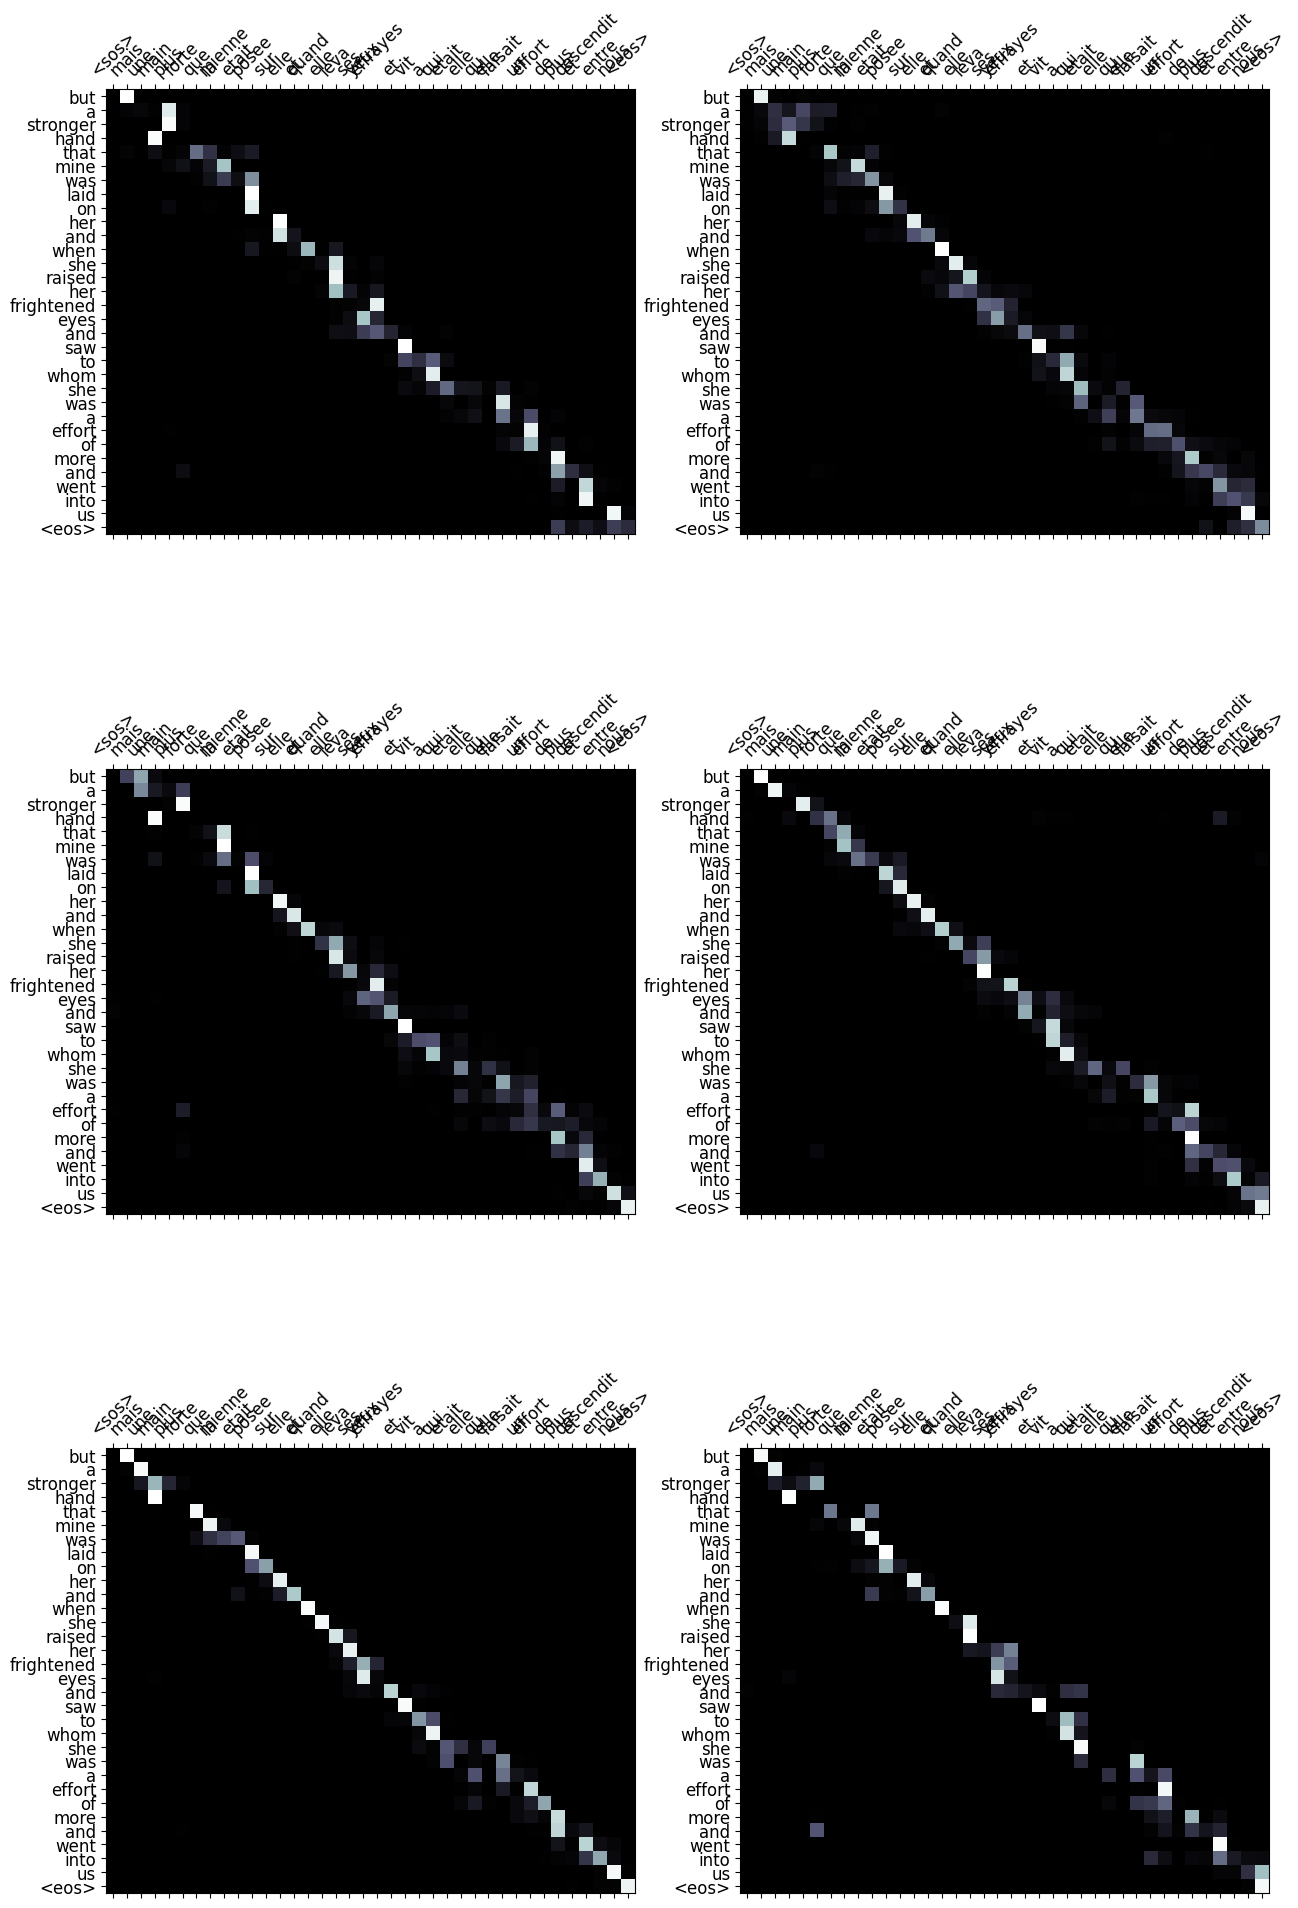

In [470]:
display_attention(src, translation, attention)
# mother를 출력하기 위해 mutter를 참고했다는 것을 시각적으로 확인 가능

In [471]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=100):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        # G 데이터를 사전 형태로 변환한 후, 'src' 키를 사용하여 해당 데이터의 소스 문장을 추출
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 500 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    # G 아래는 디폴트값과 일치 
      # max_n : 사용할 최대 n-gram 크기를 지정
      # eights : 각 n-gram에 대한 가중치를 지정
    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    # individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    # individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    # individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    # individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    # print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}')
    # print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}')
    # print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}')
    # print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}')

    # # G 각 n-gram에 대한 가중치를 모두 동일하게 설정하는 대신에 ㅁ-gram까지의 n-gram을 고려
    #   # cf) BLEU: 더 긴 n-gram에 대해서는 더 높은 가중치를 부여
    # cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    # cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    # cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    # cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    # print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}')
    # print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}')
    # print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}')
    # print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [472]:
show_bleu(test_data, german, english, model, device)

[500/3119]
예측: ['besides', 'how', 'the', 'assemblage', 'of', 'this', 'boat', 'underwater', 'he', 'escaped', 'to', 'a', 'public', 'notice']
정답: ['besides', 'how', 'could', 'the', 'assembly', 'of', 'this', 'underwater', 'boat', 'have', 'escaped', 'public', 'notice']
[1000/3119]
예측: ['then', 'you', 'must', 'have', 'a', '<unk>', 'a', 'man', 'of', 'business', 'on', 'whom', 'you', 'are', '<unk>', 'interests', 'interests', 'to', 'a', 'fair', 'rate']
정답: ['then', 'you', 'must', 'have', 'some', 'confidant', 'some', 'safe', 'man', 'of', 'business', 'who', 'pays', 'you', 'interest', 'at', 'a', 'fair', 'rate']
[1500/3119]
예측: ['and', 'didnt', 'we', 'find', 'your', 'sheets', 'were', 'not', '<unk>']
정답: ['and', 'was', 'it', 'not', 'discovered', 'that', 'your', 'sheets', 'were', 'unhemmed']
[2000/3119]
예측: ['ah']
정답: ['ah']
[2500/3119]
예측: ['alas']
정답: ['alas']
[3000/3119]
예측: ['let', 'him', 'live', 'with', 'me', 'in', 'the', 'exchange', 'of', 'kindness', 'and', 'instead', 'of', 'a', 'wound', 'i', 'w